# STOR 320 Intro to Data Science

## LAB 12 - CART

In [33]:
import numpy as np
import pandas as pd

### Data Preprocessing from lecture

In [34]:
parole = pd.read_csv("NYCparole.csv")
parole['Violator'] = parole['Violator'].astype('int64')
parole_enc = pd.get_dummies(parole, columns = ['Class'])

In [51]:
from sklearn.model_selection import train_test_split, cross_val_score

y = parole_enc['Violator']
X = parole_enc.drop(['Violator'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,  
                                                    stratify=parole_enc['Violator'],
                                                    random_state=88,)
X_train.shape, X_test.shape

((4271, 10), (1831, 10))

### Decision Tree Classifier

`skelarn`'s `DecisionTreeClassifier` is just one of many implementations that we can use for our classification problem

In [36]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 

### 1. Create a CART model to predict the column `violator`

Set `ccp_alpha` as 0.003. 

Visualize the CART model using `plot_tree()`

How many nodes are there in the tree? How many nodes have prediction being 1? 

Node count = 5


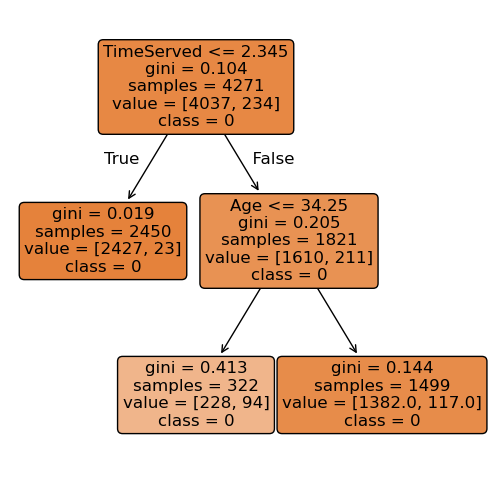

In [38]:
dtc = DecisionTreeClassifier(min_samples_leaf=5, 
                             ccp_alpha=0.003,
                             random_state = 88)

dtc = dtc.fit(X_train, y_train)

print('Node count =', dtc.tree_.node_count)
plt.figure(figsize=(6,6))
plot_tree(dtc, 
          feature_names=X_train.columns.tolist(), 
          class_names=['0','1'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12) 
plt.show()

5 nodes in the tree, 0 nodes with prediction of 1

### 2. Create a CART model to predict the column `violator`

Set `ccp_alpha` as 0.007. Set the ratio of the costs between `false positive` and `false negative` be `20: 1`.

Visualize the CART model using `plot_tree()`

How many nodes are there in the tree? How many nodes have prediction being 1?

Node count = 11


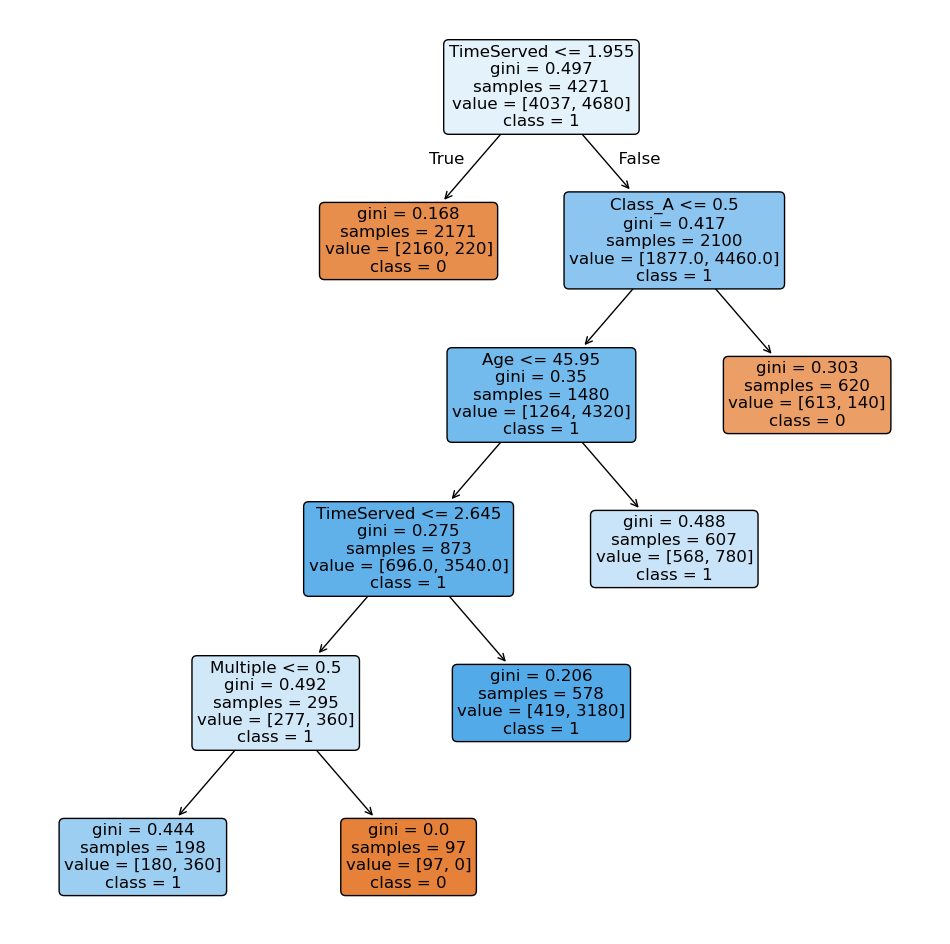

In [48]:
dtc2 = DecisionTreeClassifier(min_samples_leaf=5, 
                             ccp_alpha=0.007,
                             class_weight = {0: 1, 1: 20},
                             random_state = 88)

dtc2 = dtc2.fit(X_train, y_train)

print('Node count =', dtc2.tree_.node_count)
plt.figure(figsize=(12,12))
plot_tree(dtc2, 
          feature_names=X_train.columns.tolist(), 
          class_names=['0','1'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12) 
plt.show()

### 3. Calculate the confusion matrix of the CART model in problem 2.

In [49]:
y_pred = dtc2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm) 
print('Precision:',precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))

Confusion Matrix : 
 [[1239  491]
 [   7   94]]
Precision: 0.1606837606837607
Recall: 0.9306930693069307


### 4. CROSS-VALIDATION

In Problem 2, setting `ccp_alpha` as 0.007 may not be the best choice. Use cross-validation to determine the best value of `ccp_alpha` within the interval `[0, 0.1]`. Use `accuracy` as the score to select the best value.

- Visualize the accuracy as a function of `ccp_alpha`.

- Visualize the CART model using the selected `ccp_alpha`. Calculate the confusion matrix.

In [52]:
ccp_alpha_values = np.linspace(0, 0.1, num=50)

accuracy_scores = []

for alpha in ccp_alpha_values:
    model = DecisionTreeClassifier(ccp_alpha=alpha)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    accuracy_scores.append(scores.mean())

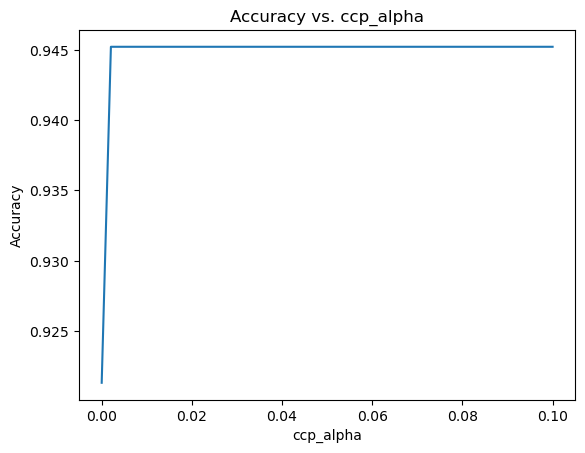

In [53]:
plt.plot(ccp_alpha_values, accuracy_scores)
plt.xlabel('ccp_alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. ccp_alpha')
plt.show()

Node count = 65


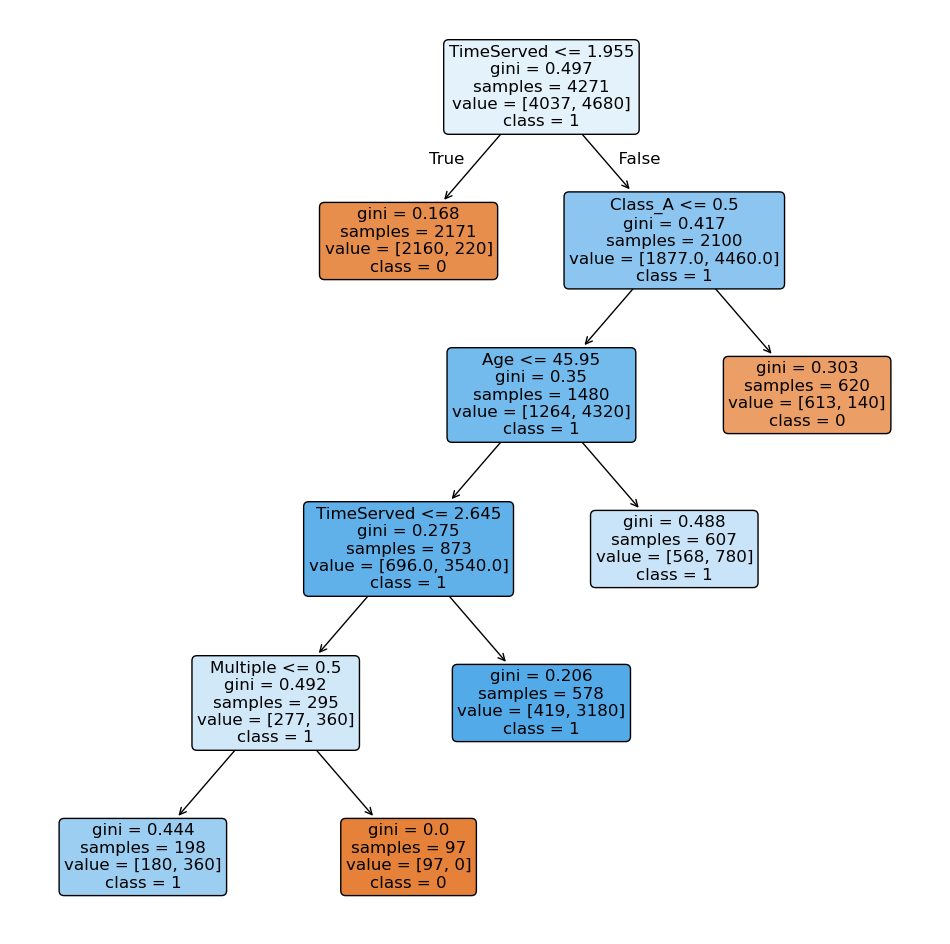

In [58]:
best_alpha = ccp_alpha_values[np.argmax(accuracy_scores)]

final_model = DecisionTreeClassifier(ccp_alpha=best_alpha)
final_model.fit(X_train, y_train)

dtc3 = DecisionTreeClassifier(min_samples_leaf=5, 
                             ccp_alpha=best_alpha,
                             class_weight = {0: 1, 1: 20},
                             random_state = 88)

dtc3 = dtc3.fit(X_train, y_train)

print('Node count =', dtc3.tree_.node_count)
plt.figure(figsize=(12,12))
plot_tree(dtc2, 
          feature_names=X_train.columns.tolist(), 
          class_names=['0','1'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12) 
plt.show()

In [59]:
y_pred = dtc3.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm) 
print('Precision:',precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))

Confusion Matrix : 
 [[1399  331]
 [  17   84]]
Precision: 0.20240963855421687
Recall: 0.8316831683168316


### 5. Select `ccp_alpha` based on Custom Loss Function

In [60]:
def average_loss_function(y_test, y_pred):
    
    weights = np.array([20 if i == 1 else 1 for i in y_test])
    
    return np.mean(weights*(y_test != y_pred))

- Is the above `ccp_alpha` the same as the misclassification rate? If not, what is the meaning of the above loss function?

- Use the above loss function to select the best value of `ccp_alpha` for Problem 2.

- Visualize the accuracy as a function of `ccp_alpha`.

- Visualize the CART model using the selected `ccp_alpha`. Calculate the confusion matrix.

In [61]:
from sklearn.metrics import make_scorer          

No, it’s not the same. The misclassification rate counts the percentage of incorrect predictions. The custom loss function adds a weight to the misclassification cost for different classes

In [71]:
custom_loss_scores = []

for alpha in ccp_alpha_values:
    model = DecisionTreeClassifier(ccp_alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    loss = average_loss_function(y_test, y_pred)
    custom_loss_scores.append(loss)

best_alpha_custom = ccp_alpha_values[np.argmin(custom_loss_scores)]

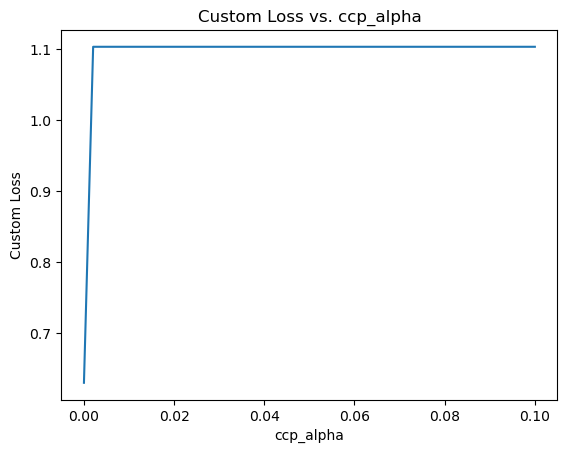

In [73]:
plt.plot(ccp_alpha_values, custom_loss_scores)
plt.xlabel('ccp_alpha')
plt.ylabel('Custom Loss')
plt.title('Custom Loss vs. ccp_alpha')
plt.show()

Node count = 345


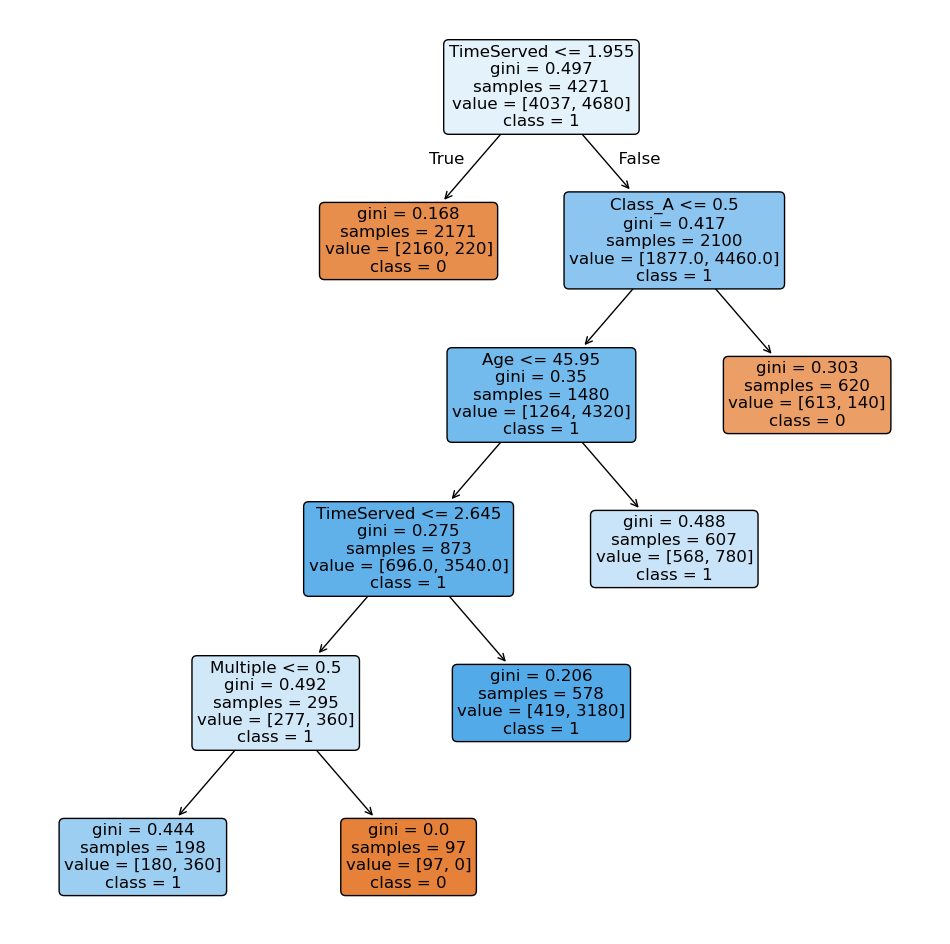

In [76]:
dtc4 = DecisionTreeClassifier(min_samples_leaf=5, 
                             ccp_alpha=best_alpha_custom,
                             class_weight = {0: 1, 1: 20},
                             random_state = 88)

dtc4 = dtc4.fit(X_train, y_train)

print('Node count =', dtc4.tree_.node_count)
plt.figure(figsize=(12,12))
plot_tree(dtc2, 
          feature_names=X_train.columns.tolist(), 
          class_names=['0','1'], 
          filled=True,
          impurity=True,
          rounded=True,
          fontsize=12) 
plt.show()

In [77]:
y_pred = dtc4.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm) 
print('Precision:',precision_score(y_test, y_pred))
print('Recall:',recall_score(y_test, y_pred))

Confusion Matrix : 
 [[1534  196]
 [  33   68]]
Precision: 0.25757575757575757
Recall: 0.6732673267326733
